In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['vidya-clb-category', 'vidya-clb']


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

# Load dataset & Overview

In [3]:
train = pd.read_csv('../input/vidya-clb/train_5clrc8b/train.csv')
test = pd.read_csv('../input/vidya-clb/test_jwt0mqh/test.csv')
submission = pd.read_csv('../input/vidya-clb/sample_submission_dlc0jkw/sample_submission.csv')
test = pd.read_csv('../input/vidya-clb/test_jwt0mqh/test.csv')
dictio = pd.read_excel('../input/vidya-clb/train_5clrc8b/Data_Dictionary.xlsx')

In [4]:
print(train.shape)
print(test.shape)

(341424, 24)
(146765, 23)


In [5]:
train.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,05/04/18,05/04/18,06/04/18,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,23/01/15,11/04/15,16/04/15,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,28/01/15,01/02/15,05/02/15,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,02/05/15,11/06/15,16/06/15,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,02/09/15,14/12/15,19/12/15,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


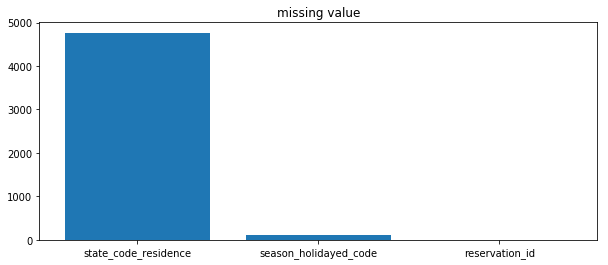

In [6]:
plt.figure(figsize=(10,4))
plt.title('missing value')
table = train.isnull().sum().reset_index().sort_values(0, ascending=False).iloc[:3,:]
plt.bar(table['index'], table[0])

del table

only 2 columns have missing values

# Data Preparation

## Change data types and handle missing values

### Train

In [7]:
train['booking_date'] = train['booking_date'].apply(lambda x :datetime.strptime(x, '%d/%m/%y'))
train['checkin_date'] = train['checkin_date'].apply(lambda x :datetime.strptime(x, '%d/%m/%y'))
train['checkout_date'] = train['checkout_date'].apply(lambda x :datetime.strptime(x, '%d/%m/%y'))

In [8]:
col_cat = ['channel_code', 'main_product_code', 'resort_region_code',
           'resort_type_code', 'room_type_booked_code' , 'season_holidayed_code',
           'state_code_residence' , 'state_code_resort', 'booking_type_code', 'persontravellingid']

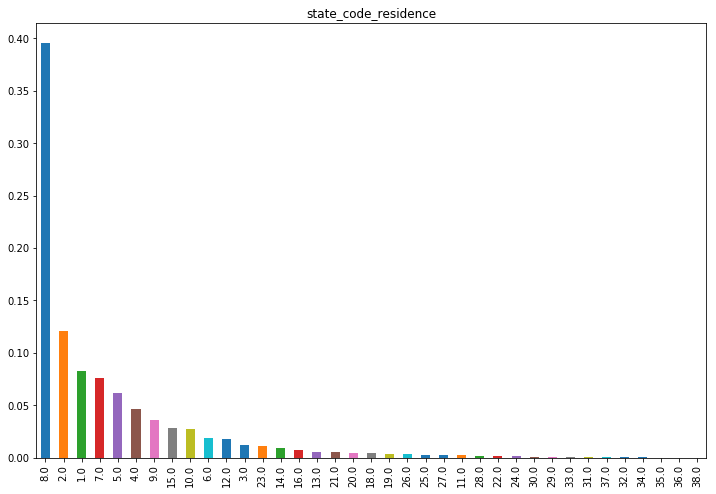

In [9]:
plt.figure(figsize=(12, 8))
plt.title('state_code_residence')
(train['state_code_residence'].value_counts() / len(train)).plot.bar()

almost 40% state_code_residence is number 8.0 and all missing values are being changed to be number 8.0

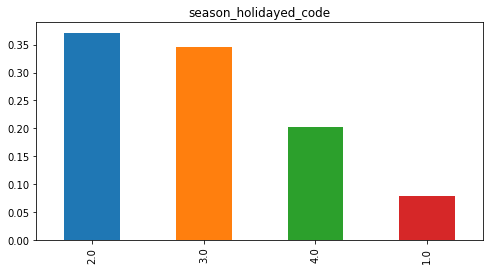

In [10]:
plt.figure(figsize=(8, 4))
plt.title('season_holidayed_code')
(train['season_holidayed_code'].value_counts() / len(train)).plot.bar()

Number 2 and 3 are slightly different

In [11]:
for i in col_cat:
    train[i] = train[i].astype('category')

In [12]:
train['state_code_residence'][train['state_code_residence'].isnull()] = 8.0
train['season_holidayed_code'][train['season_holidayed_code'].isnull()] = 2.0

In [13]:
for i in test.columns:
    if train[i].dtypes == 'int64':
        train[i] = pd.to_numeric(train[i], downcast='signed')

### Test

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146765 entries, 0 to 146764
Data columns (total 23 columns):
reservation_id              146765 non-null object
booking_date                146765 non-null object
checkin_date                146765 non-null object
checkout_date               146765 non-null object
channel_code                146765 non-null int64
main_product_code           146765 non-null int64
numberofadults              146765 non-null int64
numberofchildren            146765 non-null int64
persontravellingid          146765 non-null int64
resort_region_code          146765 non-null int64
resort_type_code            146765 non-null int64
room_type_booked_code       146765 non-null int64
roomnights                  146765 non-null int64
season_holidayed_code       146730 non-null float64
state_code_residence        144505 non-null float64
state_code_resort           146765 non-null int64
total_pax                   146765 non-null int64
member_age_buckets          146

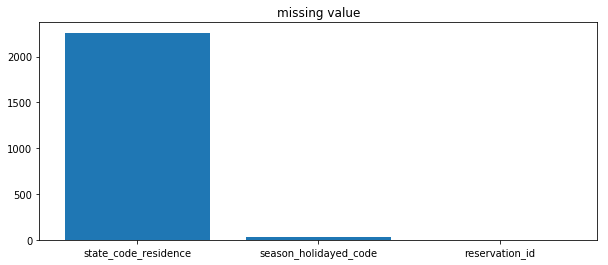

In [15]:
plt.figure(figsize=(10,4))
plt.title('missing value')
table = test.isnull().sum().reset_index().sort_values(0, ascending=False).iloc[:3,:]
plt.bar(table['index'], table[0])

del table

In [16]:
test['booking_date'] = test['booking_date'].apply(lambda x :datetime.strptime(x, '%d/%m/%y'))
test['checkin_date'] = test['checkin_date'].apply(lambda x :datetime.strptime(x, '%d/%m/%y'))
test['checkout_date'] = test['checkout_date'].apply(lambda x :datetime.strptime(x, '%d/%m/%y'))

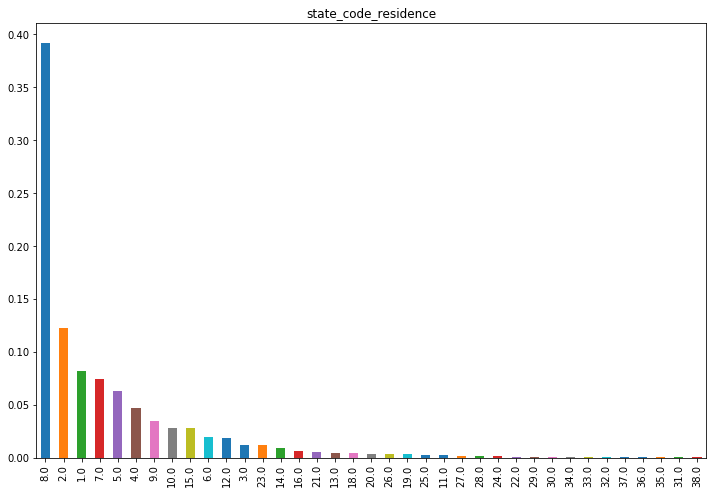

In [17]:
plt.figure(figsize=(12, 8))
plt.title('state_code_residence')
(test['state_code_residence'].value_counts() / len(test)).plot.bar()

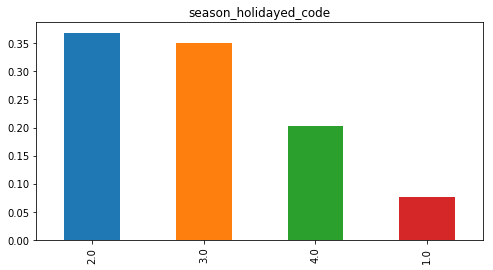

In [18]:
plt.figure(figsize=(8, 4))
plt.title('season_holidayed_code')
(test['season_holidayed_code'].value_counts() / len(test)).plot.bar()

In [19]:
for i in col_cat:
    test[i] = test[i].astype('category')

In [20]:
test['state_code_residence'][test['state_code_residence'].isnull()] = 8.0
test['season_holidayed_code'][test['season_holidayed_code'].isnull()] = 2.0

In [21]:
for i in test.columns:
    if test[i].dtypes == 'int64':
        test[i] = pd.to_numeric(test[i], downcast='signed')

## Correcting booking date, checkin date, and checkout date

### Train

In [22]:
((train['checkin_date'] - train['booking_date']).sort_values()[:12])

15    -2219 days
34    -2210 days
79    -2206 days
81    -2204 days
60    -2203 days
113   -2188 days
116   -2183 days
129   -2178 days
130   -2178 days
147   -2175 days
149   -2174 days
155   -2172 days
dtype: timedelta64[ns]

We have 12 samples that have negative number and it doesn't make sense because We have to book the reservation before check in

In [23]:
((train['checkout_date'] - train['checkin_date']) < '0 day').sum()

0

we don't have negative number so it makes a sense

In [24]:
train.iloc[:,1:4][(train['checkin_date'] - train['booking_date']) < '0 day']

,booking_date,checkin_date,checkout_date
15,2018-04-05,2012-03-08,2012-03-11
34,2018-03-31,2012-03-12,2012-03-18
60,2018-04-05,2012-03-24,2012-03-25
79,2018-04-05,2012-03-21,2012-03-25
81,2018-04-05,2012-03-23,2012-03-26
113,2018-04-06,2012-04-09,2012-04-11
116,2018-04-06,2012-04-14,2012-04-15
129,2018-04-06,2012-04-19,2012-04-21
130,2018-04-06,2012-04-19,2012-04-21
147,2018-04-06,2012-04-22,2012-04-26


we see an odd year from booking_date '2018'. In my opinion, it will make sense if the year from booking date are 2012

In [25]:
slice_checkin = (train['checkin_date'] - train['booking_date']) < '0 day'

In [26]:
for i in list((train['booking_date'][slice_checkin]).index):
    train['booking_date'][i] = train['booking_date'][i].replace(year=2012)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
train.iloc[:,1:4][(train['checkin_date'] - train['booking_date']) < '0 day']

,booking_date,checkin_date,checkout_date
15,2012-04-05,2012-03-08,2012-03-11
34,2012-03-31,2012-03-12,2012-03-18
60,2012-04-05,2012-03-24,2012-03-25
79,2012-04-05,2012-03-21,2012-03-25
81,2012-04-05,2012-03-23,2012-03-26


we still have 5 samples that have negative numbers. It seems that booking month should be 3 and it will be same with check in and check out date

In [28]:
slice_checkin = (train['checkin_date'] - train['booking_date']) < '0 day'
for i in list((train['booking_date'][slice_checkin]).index):
    train['booking_date'][i] = train['booking_date'][i].replace(month=3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
train.iloc[:,1:4][(train['checkin_date'] - train['booking_date']) < '0 day']

,booking_date,checkin_date,checkout_date
34,2012-03-31,2012-03-12,2012-03-18


we still have 1 sample. It doesn't make sanse if we booked a ticket in day 31 and we checked in day 12 then we checkout in day 18. Maybe, the user made a mistake input and their intention is day 3, so I will change day 31 to day 3

In [30]:
slice_checkin = (train['checkin_date'] - train['booking_date']) < '0 day'
for i in list((train['booking_date'][slice_checkin]).index):
    train['booking_date'][i] = train['booking_date'][i].replace(day=3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
train.iloc[:,1:4][(train['checkin_date'] - train['booking_date']) < '0 day']

,booking_date,checkin_date,checkout_date


finally, we don't have a negative number.

### Test

In [32]:
((test['checkin_date'] - test['booking_date']).sort_values()[:5])

41      -2177 days
57      -2169 days
74575       0 days
74591       0 days
74601       0 days
dtype: timedelta64[ns]

we have 2 negative number of samples 

In [33]:
((test['checkout_date'] - test['checkin_date']).sort_values()[:5])

0       1 days
70310   1 days
70311   1 days
70323   1 days
70328   1 days
dtype: timedelta64[ns]

We don't have a negative numbers of samples

In [34]:
test.iloc[:,1:4][(test['checkin_date'] - test['booking_date']) < '0 day']

,booking_date,checkin_date,checkout_date
41,2018-04-06,2012-04-20,2012-04-24
57,2018-04-06,2012-04-28,2012-05-01


I will change the year of booking_date to 2012 as same as above in train

In [35]:
slice_checkin = (test['checkin_date'] - test['booking_date']) < '0 day'
for i in list((test['booking_date'][slice_checkin]).index):
    test['booking_date'][i] = test['booking_date'][i].replace(year=2012)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
test.iloc[:,1:4][(test['checkin_date'] - test['booking_date']) < '0 day']

,booking_date,checkin_date,checkout_date


# EDA

## Booking date

### Train

In [37]:
tes = train[['booking_date', 'amount_spent_per_room_night_scaled']].set_index(train['booking_date'], drop=True)

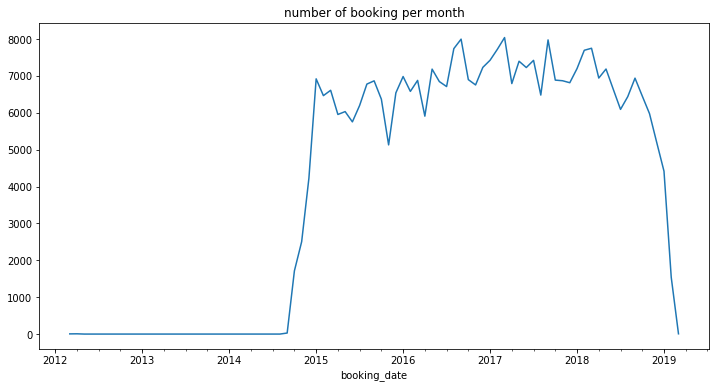

In [38]:
plt.figure(figsize=(12, 6))
plt.title('number of booking per month')
tes.resample('M')['booking_date'].count().plot.line()

It is hard to see the pattern using line bar. First, we have to look the test because sometimes the date are not in order. Second, in my opninion, the hospitality has the seasonal product and adding the month maybe help us to see it

In [39]:
test['booking_date'].sort_values().head(10)

57     2012-04-06
41     2012-04-06
9388   2014-09-03
5783   2014-09-03
59     2014-09-04
1676   2014-09-05
62     2014-09-16
1287   2014-09-17
66     2014-09-29
67     2014-09-29
Name: booking_date, dtype: datetime64[ns]

we see train and test data are randomly splitted

In [40]:
tes.resample('M')['booking_date'].count().describe()

count      85.000000
mean     4016.752941
std      3319.693251
min         0.000000
25%         0.000000
50%      5979.000000
75%      6880.000000
max      8042.000000
Name: booking_date, dtype: float64

In [41]:
del tes

### Add month, day, year

In [42]:
train['booking_day'] = train['booking_date'].dt.day_name()
test['booking_day'] = test['booking_date'].dt.day_name()

train['booking_month'] = train['booking_date'].dt.month_name()
test['booking_month'] = test['booking_date'].dt.month_name()

train['booking_year'] = train['booking_date'].dt.year
test['booking_year'] = test['booking_date'].dt.year

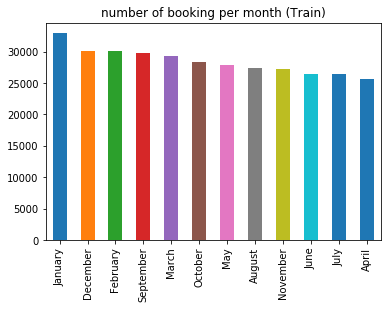

In [43]:
plt.title('number of booking per month (Train)')
train['booking_month'].value_counts().plot.bar()

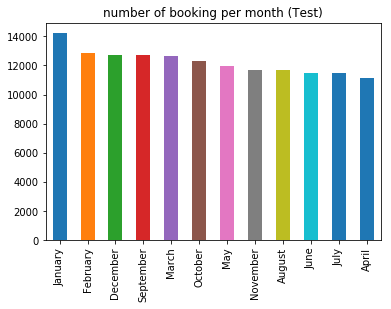

In [44]:
plt.title('number of booking per month (Test)')
test['booking_month'].value_counts().plot.bar()

both train and test have highest booking in January

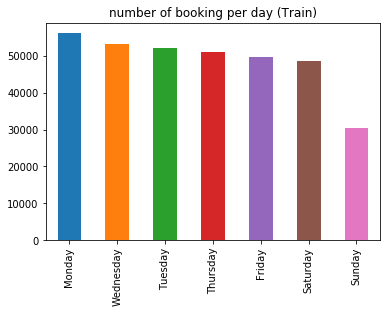

In [45]:
plt.title('number of booking per day (Train)')
train['booking_day'].value_counts().plot.bar()

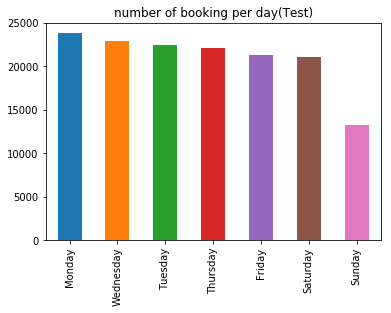

In [46]:
plt.title('number of booking per day(Test)')
test['booking_day'].value_counts().plot.bar()

We see bookings are higher in weekday rather than weekend.

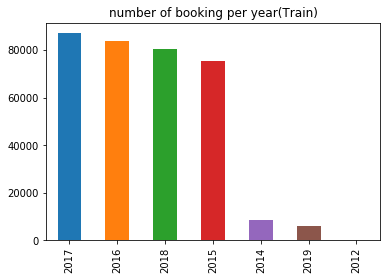

In [47]:
plt.title('number of booking per year(Train)')
train['booking_year'].value_counts().plot.bar()

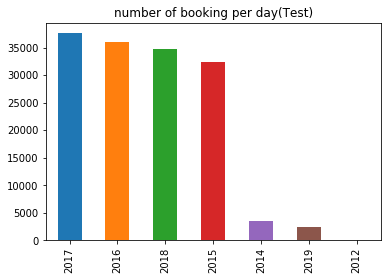

In [48]:
plt.title('number of booking per day(Test)')
test['booking_year'].value_counts().plot.bar()

both train and test have highest booking in 2017

## Checkin_date

In [49]:
tes = train[['checkin_date', 'amount_spent_per_room_night_scaled']].set_index(train['checkin_date'], drop=True)

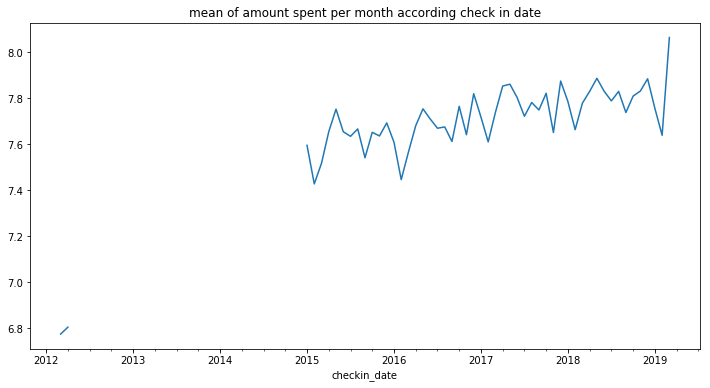

In [50]:
plt.figure(figsize=(12, 6))
plt.title('mean of amount spent per month according check in date')
tes.resample('M')['amount_spent_per_room_night_scaled'].mean().plot.line()

In [51]:
tes.resample('M')['amount_spent_per_room_night_scaled'].mean().describe()

count    53.000000
mean      7.684678
std       0.213714
min       6.774608
25%       7.639674
50%       7.718755
75%       7.803334
max       8.064831
Name: amount_spent_per_room_night_scaled, dtype: float64

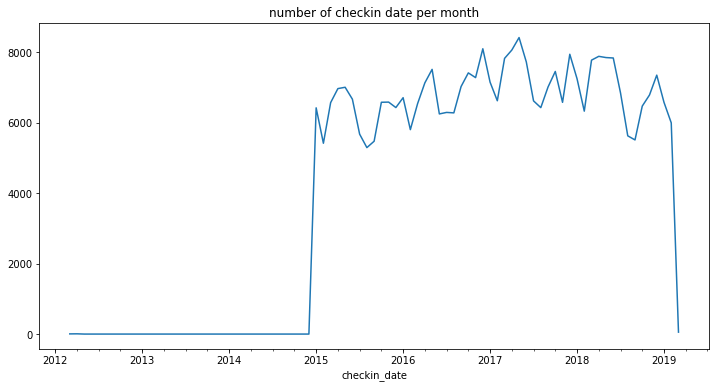

In [52]:
plt.figure(figsize=(12, 6))
plt.title('number of checkin date per month')
tes.resample('M')['checkin_date'].count().plot.line()

In [53]:
tes.resample('M')['checkin_date'].count().describe()

count      85.000000
mean     4016.752941
std      3430.938116
min         0.000000
25%         0.000000
50%      5996.000000
75%      6968.000000
max      8417.000000
Name: checkin_date, dtype: float64

### Add month, day, year

In [54]:
train['checkin_day'] = train['checkin_date'].dt.day_name()
test['checkin_day'] = test['checkin_date'].dt.day_name()

train['checkin_month'] = train['checkin_date'].dt.month_name()
test['checkin_month'] = test['checkin_date'].dt.month_name()

train['checkin_year'] = train['checkin_date'].dt.year
test['checkin_year'] = test['checkin_date'].dt.year

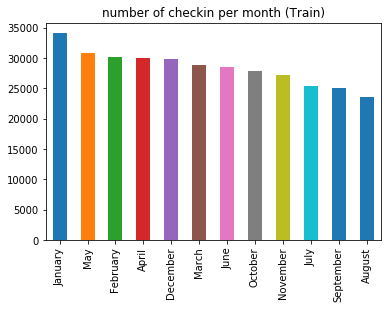

In [55]:
plt.title('number of checkin per month (Train)')
train['checkin_month'].value_counts().plot.bar()

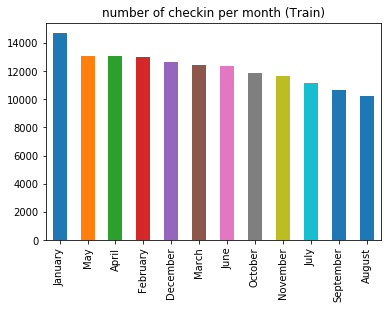

In [56]:
plt.title('number of checkin per month (Train)')
test['checkin_month'].value_counts().plot.bar()

Most people are check in in January

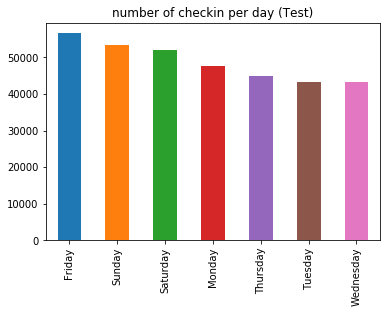

In [57]:
plt.title('number of checkin per day (Test)')
train['checkin_day'].value_counts().plot.bar()

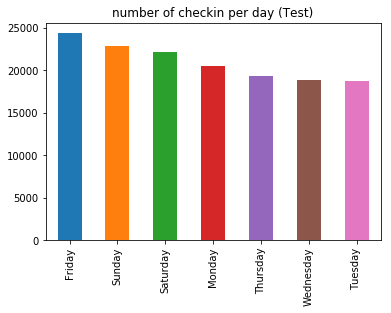

In [58]:
plt.title('number of checkin per day (Test)')
test['checkin_day'].value_counts().plot.bar()

Most people are checkin in Friday

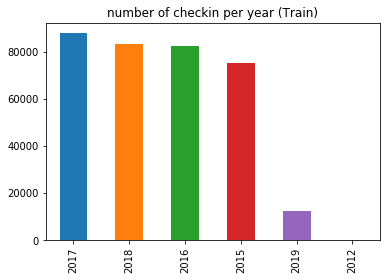

In [59]:
plt.title('number of checkin per year (Train)')
train['checkin_year'].value_counts().plot.bar()

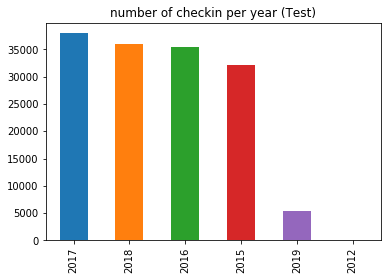

In [60]:
plt.title('number of checkin per year (Test)')
test['checkin_year'].value_counts().plot.bar()

Most people are check in 2017

## Checkout_date

In [61]:
tes = train[['checkout_date', 'amount_spent_per_room_night_scaled']].set_index(train['checkout_date'], drop=True)

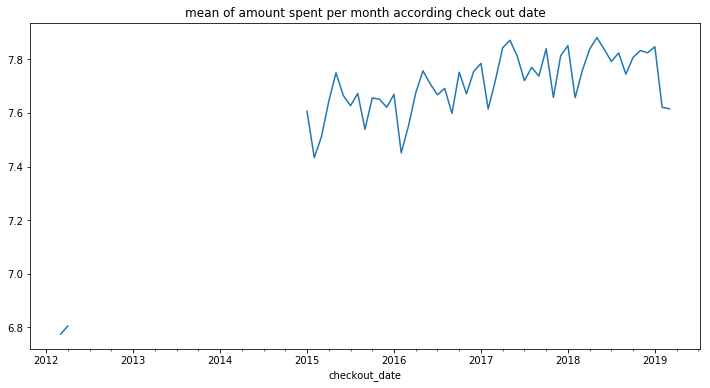

In [62]:
plt.figure(figsize=(12, 6))
plt.title('mean of amount spent per month according check out date')
tes.resample('M')['amount_spent_per_room_night_scaled'].mean().plot.line()

In [63]:
tes.resample('M')['amount_spent_per_room_night_scaled'].mean().describe()

count    53.000000
mean      7.676252
std       0.206795
min       6.774608
25%       7.627351
50%       7.708928
75%       7.807843
max       7.881744
Name: amount_spent_per_room_night_scaled, dtype: float64

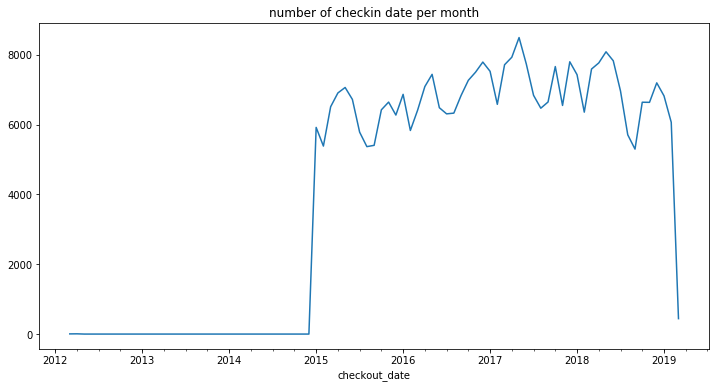

In [64]:
plt.figure(figsize=(12, 6))
plt.title('number of checkin date per month')
tes.resample('M')['checkout_date'].count().plot.line()

In [65]:
tes.resample('M')['amount_spent_per_room_night_scaled'].count().describe()

count      85.000000
mean     4016.752941
std      3422.098395
min         0.000000
25%         0.000000
50%      5921.000000
75%      6868.000000
max      8495.000000
Name: amount_spent_per_room_night_scaled, dtype: float64

### Add month, day, year

In [66]:
train['checkout_day'] = train['checkout_date'].dt.day_name()
test['checkout_day'] = test['checkout_date'].dt.day_name()

train['checkout_month'] = train['checkout_date'].dt.month_name()
test['checkout_month'] = test['checkout_date'].dt.month_name()

train['checkout_year'] = train['checkout_date'].dt.year
test['checkout_year'] = test['checkout_date'].dt.year

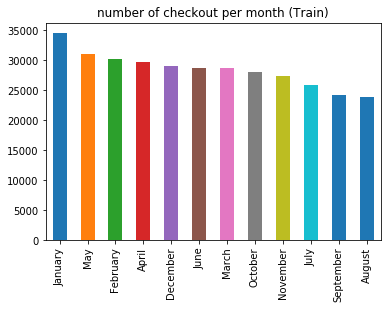

In [67]:
plt.title('number of checkout per month (Train)')
train['checkout_month'].value_counts().plot.bar()

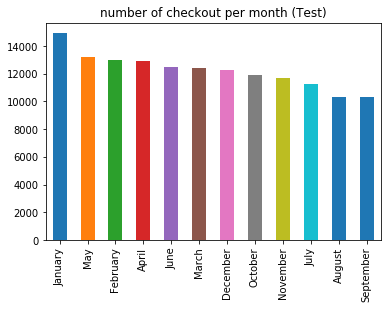

In [68]:
plt.title('number of checkout per month (Test)')
test['checkout_month'].value_counts().plot.bar()

Most people are check out in January

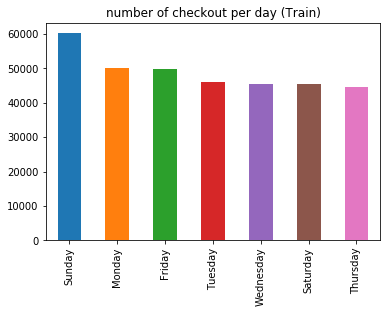

In [69]:
plt.title('number of checkout per day (Train)')
train['checkout_day'].value_counts().plot.bar()

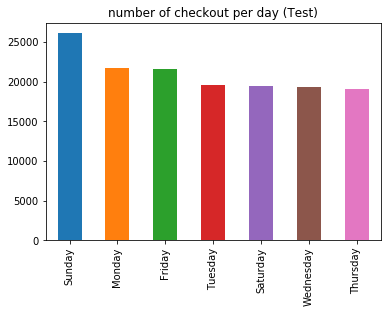

In [70]:
plt.title('number of checkout per day (Test)')
test['checkout_day'].value_counts().plot.bar()

Most people are check out in Sunday. In checkin day, the highest people who checked in are in Friday. We can conclude most people are spending their holiday in weekend.

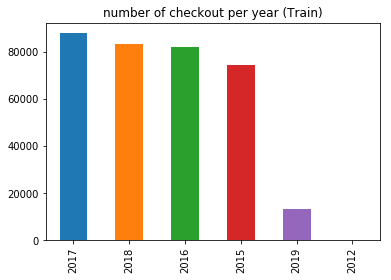

In [71]:
plt.title('number of checkout per year (Train)')
train['checkout_year'].value_counts().plot.bar()

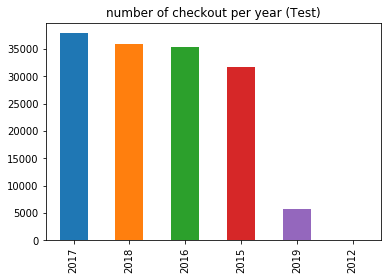

In [72]:
plt.title('number of checkout per year (Test)')
test['checkout_year'].value_counts().plot.bar()

Most people are check out in 2017

### add days between checkin and booking date

In [73]:
train['checkin_booking'] = (train['checkin_date'] - train['booking_date']).apply(lambda x : x.days)
test['checkin_booking'] = (test['checkin_date'] - test['booking_date']).apply(lambda x : x.days)

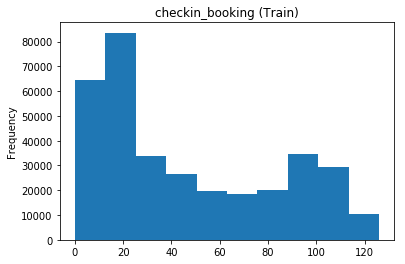

In [74]:
plt.title('checkin_booking (Train)')
train['checkin_booking'].plot.hist()

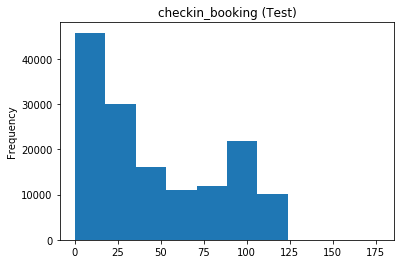

In [75]:
plt.title('checkin_booking (Test)')
test['checkin_booking'].plot.hist()

The histogram is called "bimodal" since it has two values or data ranges that appear most often in the data. A bimodal histogram shape often reflects the presence of two different processes being "mixed" in the displayed data. Maybe it is effected by season.

In [76]:
train['checkin_booking'].describe()

count    341424.000000
mean         46.162206
std          36.792224
min           0.000000
25%          15.000000
50%          33.000000
75%          82.000000
max         126.000000
Name: checkin_booking, dtype: float64

In [77]:
test['checkin_booking'].describe()

count    146765.000000
mean         46.230777
std          36.807391
min           0.000000
25%          15.000000
50%          33.000000
75%          82.000000
max         177.000000
Name: checkin_booking, dtype: float64

The expectation of checkin and booking time from people are 46 days

### add days between checkout and checkin date

In [78]:
train['checkout_checkin'] = (train['checkout_date'] - train['checkin_date']).apply(lambda x : x.days)
test['checkout_checkin'] = (test['checkout_date'] - test['checkin_date']).apply(lambda x : x.days)

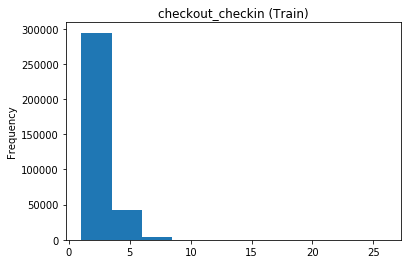

In [79]:
plt.title('checkout_checkin (Train)')
train['checkout_checkin'].plot.hist()

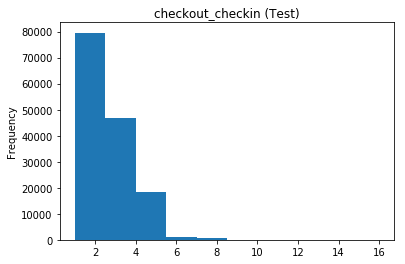

In [80]:
plt.title('checkout_checkin (Test)')
test['checkout_checkin'].plot.hist()

In [81]:
train['checkout_checkin'].describe()

count    341424.000000
mean          2.466646
std           1.093479
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          26.000000
Name: checkout_checkin, dtype: float64

In [82]:
test['checkout_checkin'].describe()

count    146765.000000
mean          2.465574
std           1.097342
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          16.000000
Name: checkout_checkin, dtype: float64

The expectation of people who spend their night in resort are 2 days

### Checkout - checkin in scatterplot

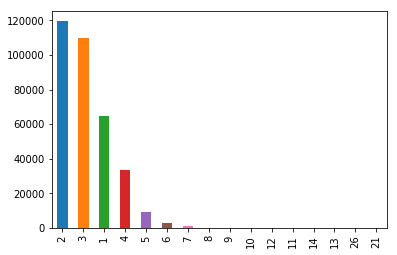

In [83]:
train['checkout_checkin'].value_counts().plot.bar()

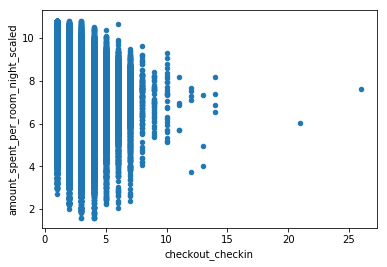

In [84]:
train.plot.scatter('checkout_checkin', 'amount_spent_per_room_night_scaled')

In [85]:
train[['checkout_checkin', 'amount_spent_per_room_night_scaled']].corr()

,checkout_checkin,amount_spent_per_room_night_scaled
checkout_checkin,1.0000,-0.1988
amount_spent_per_room_night_scaled,-0.1988,1.0000


we see checkout_checkin and amount_spent_per_room_night_scaled have relative negative small relation

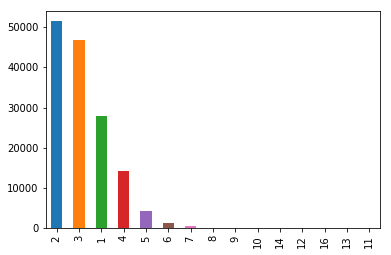

In [86]:
test['checkout_checkin'].value_counts().plot.bar()

## channel_code

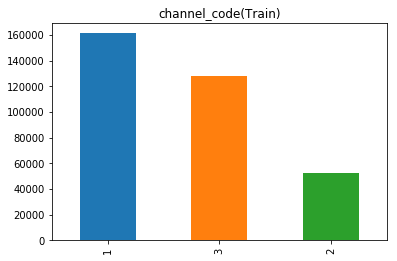

In [87]:
plt.title('channel_code(Train)')
train['channel_code'].value_counts().plot.bar()

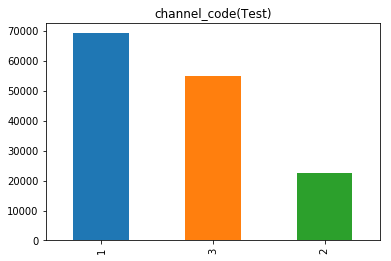

In [88]:
plt.title('channel_code(Test)')
test['channel_code'].value_counts().plot.bar()

## main_product_code

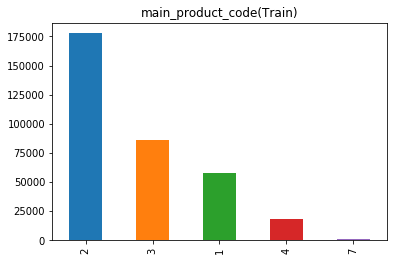

In [89]:
plt.title('main_product_code(Train)')
train['main_product_code'].value_counts().plot.bar()

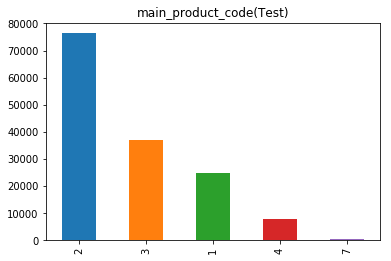

In [90]:
plt.title('main_product_code(Test)')
test['main_product_code'].value_counts().plot.bar()

## numberofadults

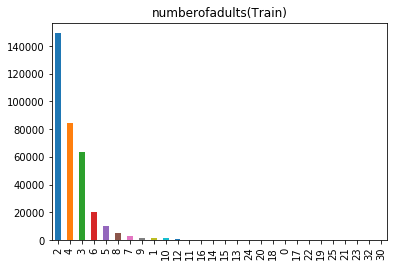

In [91]:
plt.title('numberofadults(Train)')
train['numberofadults'].value_counts().plot.bar()

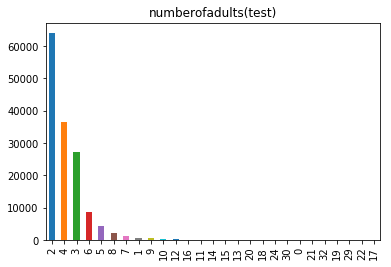

In [92]:
plt.title('numberofadults(test)')
test['numberofadults'].value_counts().plot.bar()

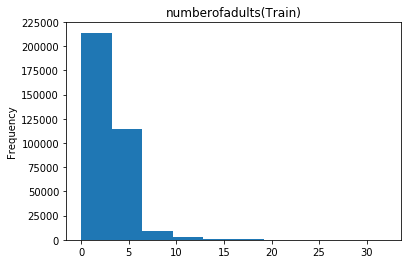

In [93]:
plt.title('numberofadults(Train)')
train['numberofadults'].plot.hist()

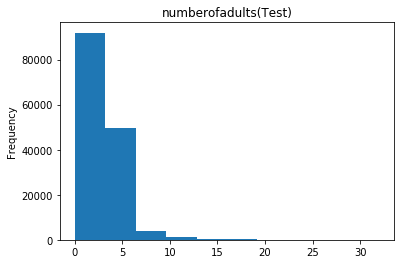

In [94]:
plt.title('numberofadults(Test)')
test['numberofadults'].plot.hist()

In [95]:
train['numberofadults'].describe()

count    341424.000000
mean          3.275361
std           1.756062
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          32.000000
Name: numberofadults, dtype: float64

In [96]:
test['numberofadults'].describe()

count    146765.000000
mean          3.275897
std           1.783842
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          32.000000
Name: numberofadults, dtype: float64

The expectation number of adults is 3 persons and we have 0 adult that doesn't make a sense

## numberofchildren

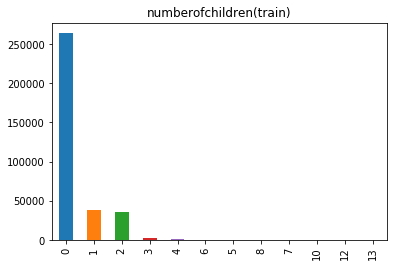

In [97]:
plt.title('numberofchildren(train)')
train['numberofchildren'].value_counts().plot.bar()

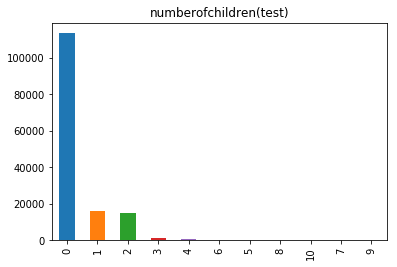

In [98]:
plt.title('numberofchildren(test)')
test['numberofchildren'].value_counts().plot.bar()

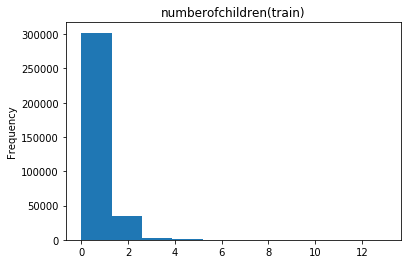

In [99]:
plt.title('numberofchildren(train)')
train['numberofchildren'].plot.hist()

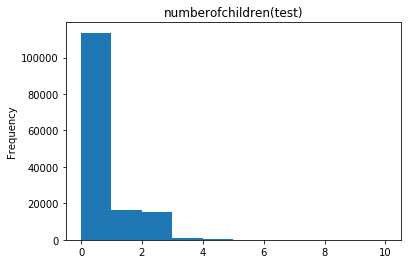

In [100]:
plt.title('numberofchildren(test)')
test['numberofchildren'].plot.hist()

In [101]:
train['numberofchildren'].describe()

count    341424.000000
mean          0.362696
std           0.758019
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: numberofchildren, dtype: float64

In [102]:
test['numberofchildren'].describe()

count    146765.000000
mean          0.362287
std           0.758218
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: numberofchildren, dtype: float64

Many people do travelling without children so maybe they are a couple young man and women. It is explained by the majority number of adults that are 2

In [103]:
train[['numberofadults', 'numberofchildren', 'total_pax']][(train['total_pax'] - (train['numberofadults'] + train['numberofchildren']) != 0)]

,numberofadults,numberofchildren,total_pax
0,2,0,3
3,2,2,2
6,2,0,1
11,2,0,4
13,2,0,3
14,2,0,4
15,2,0,3
17,2,0,4
18,2,0,4
19,2,0,4


In [104]:
train[['numberofadults', 'numberofchildren', 'total_pax']][train['numberofadults'] <= 0]

,numberofadults,numberofchildren,total_pax
5352,0,0,3
12566,0,0,3
36366,0,0,4
52102,0,0,2
68167,0,0,4
78769,0,0,4
99340,0,0,3
109998,0,0,4
155198,0,0,4
161369,0,0,6


it is hard to determine the right number between numberofadults + numberofchildren = total pax. I will use total pax and delete numberofadults and numberof children

## total_pax

In [105]:
train[['numberofadults', 'numberofchildren', 'total_pax']][train['total_pax'] == 0]

,numberofadults,numberofchildren,total_pax
19160,2,0,0
53662,2,2,0
72730,2,2,0
107887,2,2,0
113931,2,0,0
124396,2,0,0
143187,2,2,0
179743,2,0,0
181049,2,2,0
185518,2,2,0


it doesn't make sense if total_pax is 0 so I add numberofadults and numberofchildren for total pax

In [106]:
train['total_pax'][train['total_pax'] == 0] = (train['numberofchildren'][train['total_pax'] == 0] + train['numberofadults'][train['total_pax'] == 0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [107]:
train[['numberofadults', 'numberofchildren', 'total_pax']][train['total_pax'] == 0]

,numberofadults,numberofchildren,total_pax


there are no 0 total pax so I delete numberofadults and numberofchildren

In [108]:
train = train.drop(columns=['numberofadults', 'numberofchildren'])
test = test.drop(columns=['numberofadults', 'numberofchildren'])

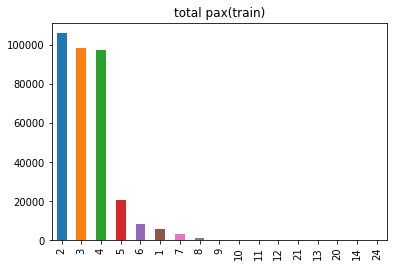

In [109]:
plt.title('total pax(train)')
train['total_pax'].value_counts().plot.bar()

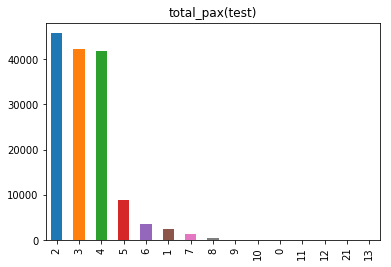

In [110]:
plt.title('total_pax(test)')
test['total_pax'].value_counts().plot.bar()

The highest total pax is 2 persons

In [111]:
train['total_pax'].describe()

count    341424.000000
mean          3.193519
std           1.167642
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          24.000000
Name: total_pax, dtype: float64

In [112]:
test['total_pax'].describe()

count    146765.000000
mean          3.188410
std           1.163872
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          21.000000
Name: total_pax, dtype: float64

the mean or expectation of the number people who travelling is 3 persons

## persontravellingid

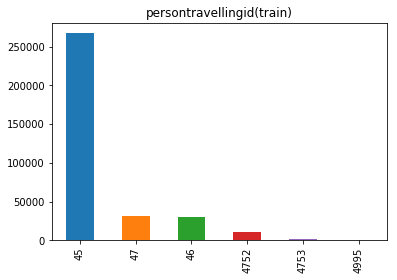

In [113]:
plt.title('persontravellingid(train)')
train['persontravellingid'].value_counts().plot.bar()

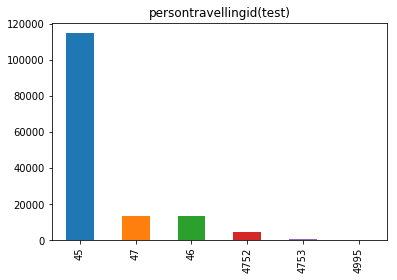

In [114]:
plt.title('persontravellingid(test)')
test['persontravellingid'].value_counts().plot.bar()

the highest type id is 45

### change data types

In [115]:
for i in train.columns:
    if train[i].dtypes == 'int64':
        train[i] = pd.to_numeric(train[i], downcast='signed')
        
for i in test.columns:
    if test[i].dtypes == 'int64':
        test[i] = pd.to_numeric(test[i], downcast='signed')

for i in ['checkout_year', 'checkin_year', 'booking_year']:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

## resort_region_code

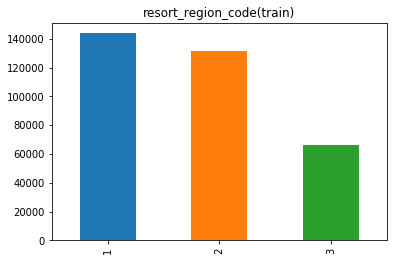

In [116]:
plt.title('resort_region_code(train)')
train['resort_region_code'].value_counts().plot.bar()

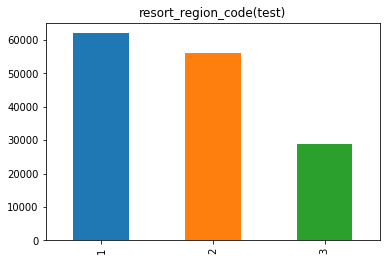

In [117]:
plt.title('resort_region_code(test)')
test['resort_region_code'].value_counts().plot.bar()

the highest visitor is in resort region 1

## resort_type_code

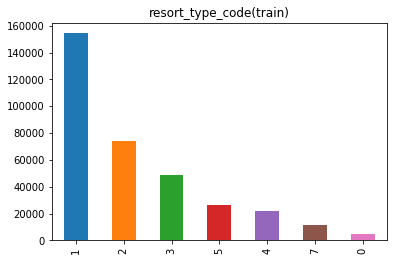

In [118]:
plt.title('resort_type_code(train)')
train['resort_type_code'].value_counts().plot.bar()

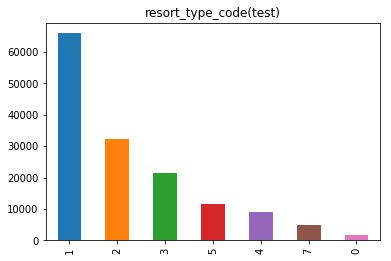

In [119]:
plt.title('resort_type_code(test)')
test['resort_type_code'].value_counts().plot.bar()

The highest visitor is in region type 1

## room_type_booked_code

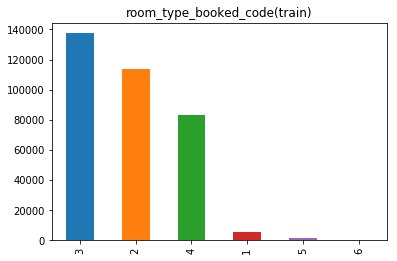

In [120]:
plt.title('room_type_booked_code(train)')
train['room_type_booked_code'].value_counts().plot.bar()

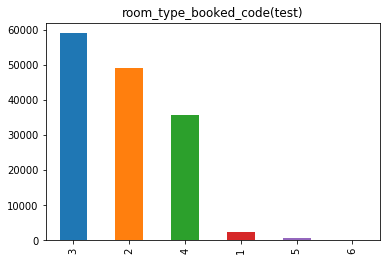

In [121]:
plt.title('room_type_booked_code(test)')
test['room_type_booked_code'].value_counts().plot.bar()

The highest room type is room type 1

## roomnights

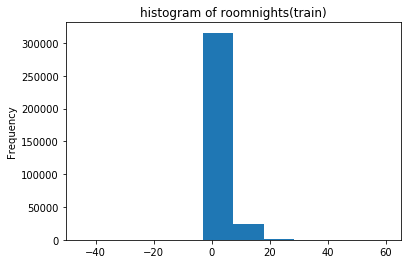

In [122]:
plt.title('histogram of roomnights(train)')
train['roomnights'].plot.hist()

we have negative numbers and 0 number are in our value and it doesn't make sense. I will change it to be the median of roomninghts

In [123]:
train['roomnights'][train['roomnights'] < 0] = train['roomnights'].median()
train['roomnights'][train['roomnights'] == 0] = train['roomnights'].median()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


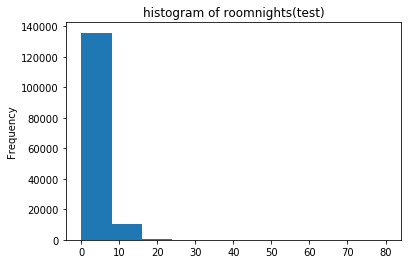

In [124]:
plt.title('histogram of roomnights(test)')
test['roomnights'].plot.hist()

same as in train, I will change the 0 number to the median roomninghts

In [125]:
test['roomnights'][test['roomnights'] == 0] = test['roomnights'].median()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


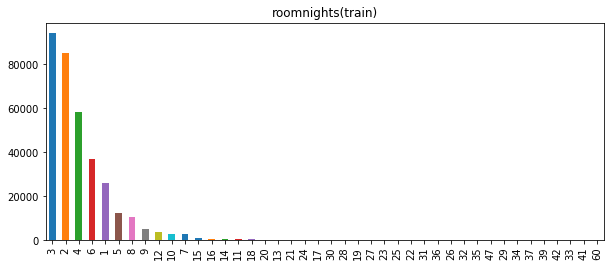

In [126]:
plt.figure(figsize=(10, 4))
plt.title('roomnights(train)')
train['roomnights'].value_counts().plot.bar()

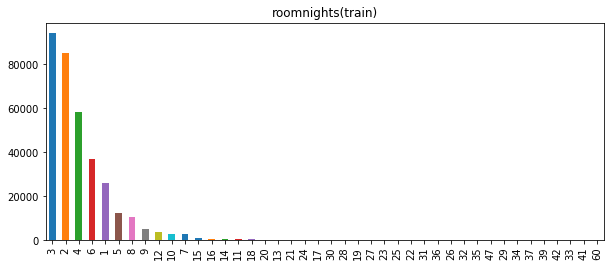

In [127]:
plt.figure(figsize=(10, 4))
plt.title('roomnights(train)')
train['roomnights'].value_counts().plot.bar()

the highest number is 3. meaning many people tend to book 3 rooms

## season_holidayed_code

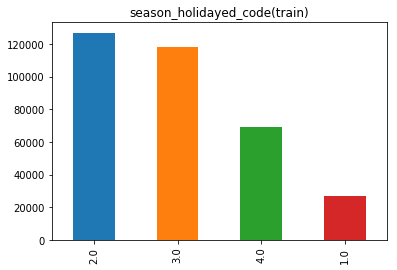

In [128]:
plt.title('season_holidayed_code(train)')
train['season_holidayed_code'].value_counts().plot.bar()

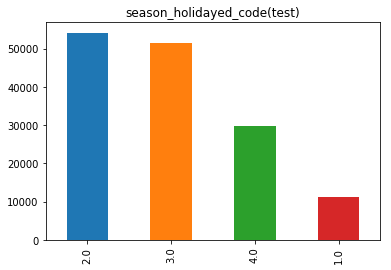

In [129]:
plt.title('season_holidayed_code(test)')
test['season_holidayed_code'].value_counts().plot.bar()

people tend to spent their holidat in season code 2

## state_code_residence

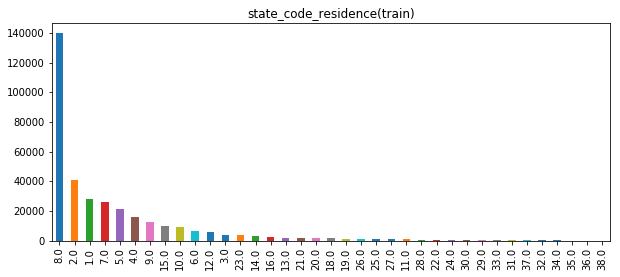

In [130]:
plt.figure(figsize=(10,4))
plt.title('state_code_residence(train)')
train['state_code_residence'].value_counts().plot.bar()

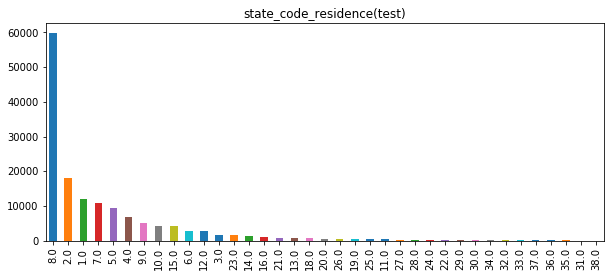

In [131]:
plt.figure(figsize=(10,4))
plt.title('state_code_residence(test)')
test['state_code_residence'].value_counts().plot.bar()

people from state code residence 8 are the highest customers for club mahindra

## state_code_resort

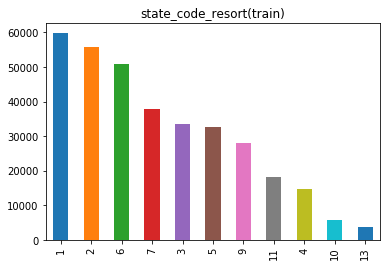

In [132]:
plt.title('state_code_resort(train)')
train['state_code_resort'].value_counts().plot.bar()

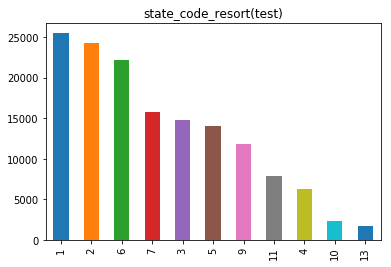

In [133]:
plt.title('state_code_resort(test)')
test['state_code_resort'].value_counts().plot.bar()

state code resort 1 is the customers favorite 

## member_age_buckets

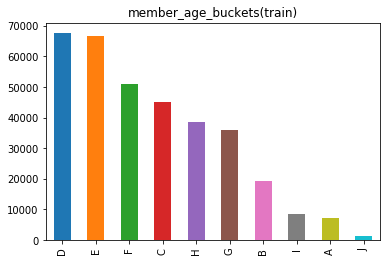

In [134]:
plt.title('member_age_buckets(train)')
train['member_age_buckets'].value_counts().plot.bar()

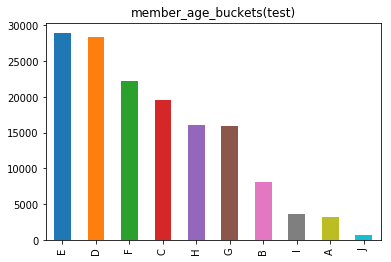

In [135]:
plt.title('member_age_buckets(test)')
test['member_age_buckets'].value_counts().plot.bar()

member age of D and E are the highest group of customers and have slightly different

## booking_type_code

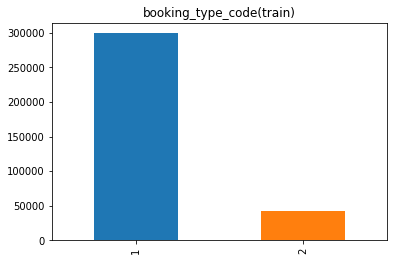

In [136]:
plt.title('booking_type_code(train)')
train['booking_type_code'].value_counts().plot.bar()

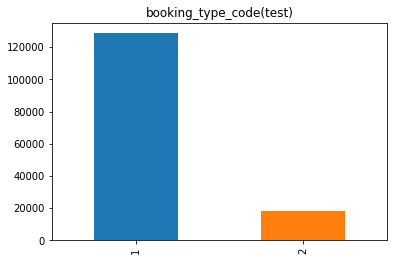

In [137]:
plt.title('booking_type_code(test)')
test['booking_type_code'].value_counts().plot.bar()

booking type code 1 is the highest

## memberid

In [138]:
train_cat = pd.DataFrame(train['memberid'])
train_cat['data'] = 'A'

test_cat = pd.DataFrame(test['memberid'])
test_cat['data'] = 'B'

In [139]:
full_cat = pd.concat([train_cat, test_cat])
full_cat['memberid'] = full_cat['memberid'].astype('category').cat.codes + 1

In [140]:
del train_cat
del test_cat

In [141]:
train['memberid'] = full_cat['memberid'][full_cat['data'] == 'A']
test['memberid'] = full_cat['memberid'][full_cat['data'] == 'B']

In [142]:
del full_cat

In [143]:
train['memberid'] = train['memberid'].astype('category')
test['memberid'] = test['memberid'].astype('category')

In [144]:
member_count =[]
for i in train['memberid']:
    for x, y in zip(train['memberid'].value_counts().reset_index()['index'], train['memberid'].value_counts().reset_index()['memberid']):
        if i == x:
            member_count.append(y)

train['member_count'] = member_count

In [145]:
member_count =[]
for x, y in zip(test['memberid'].value_counts().reset_index()['index'], test['memberid'].value_counts().reset_index()['memberid']):
    for i in test['memberid']:
        if x == i:
            member_count.append(y)
            
test['member_count'] = member_count

## cluster_code

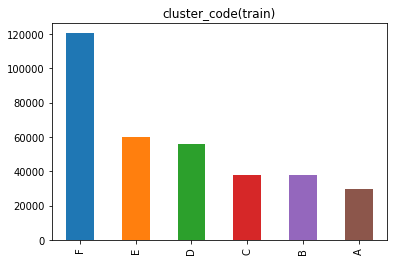

In [146]:
plt.title('cluster_code(train)')
train['cluster_code'].value_counts().plot.bar()

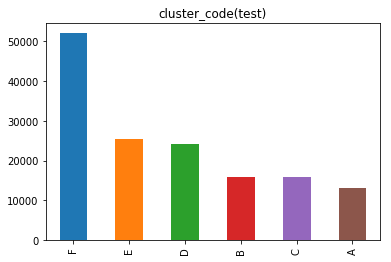

In [147]:
plt.title('cluster_code(test)')
test['cluster_code'].value_counts().plot.bar()

cluster code F has the highest number

## reservationstatusid_code

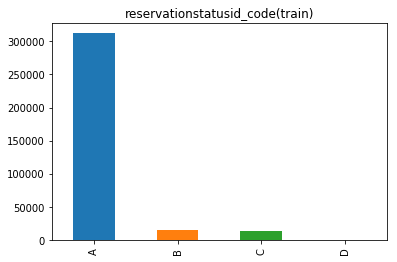

In [148]:
plt.title('reservationstatusid_code(train)')
train['reservationstatusid_code'].value_counts().plot.bar()

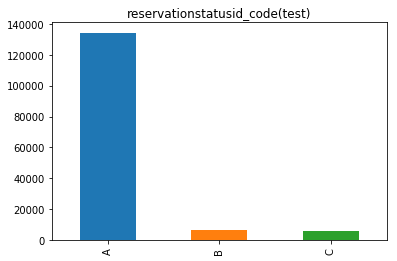

In [149]:
plt.title('reservationstatusid_code(test)')
test['reservationstatusid_code'].value_counts().plot.bar()

Reservation status id A is the highest number and test doesn't have 'D'

## resort_id

In [150]:
train_cat = pd.DataFrame(train['resort_id'])
train_cat['data'] = 'A'

test_cat = pd.DataFrame(test['resort_id'])
test_cat['data'] = 'B'

In [151]:
full_cat = pd.concat([train_cat, test_cat])
full_cat['resort_id'] = full_cat['resort_id'].astype('category').cat.codes + 1

In [152]:
train['resort_id'] = full_cat['resort_id'][full_cat['data'] == 'A']
test['resort_id'] = full_cat['resort_id'][full_cat['data'] == 'B']

In [153]:
train['resort_id'] = train['resort_id'].astype('category')
test['resort_id'] = test['resort_id'].astype('category')

In [154]:
del test_cat
del train_cat
del full_cat

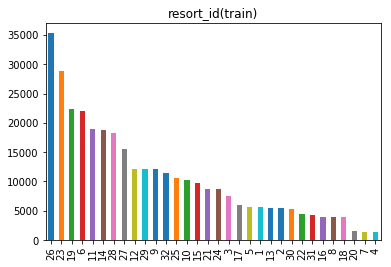

In [155]:
plt.title('resort_id(train)')
train['resort_id'].value_counts().plot.bar()

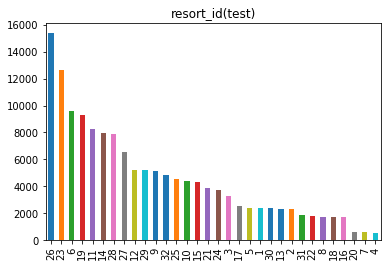

In [156]:
plt.title('resort_id(test)')
test['resort_id'].value_counts().plot.bar()

as we can see, resort id 26 has the highest number

# Dummies

In [157]:
train = train.drop(columns=['reservation_id', 'booking_date', 'checkin_date', 'checkout_date', 'memberid'])
test = test.drop(columns=['reservation_id', 'booking_date', 'checkin_date', 'checkout_date', 'memberid'])

In [158]:
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [159]:
test['reservationstatusid_code_D'] = 0

In [160]:
train.to_csv('train_clb_M', index=False)
test.to_csv('test_clb_M', index=False)

# Model

In [161]:
target = train.loc[:,'amount_spent_per_room_night_scaled']
train = train.drop(columns=['amount_spent_per_room_night_scaled'])
features = list(train.columns)

In [162]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [163]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx]
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx]
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.0459	valid_1's rmse: 1.03286
[200]	training's rmse: 1.02038	valid_1's rmse: 1.00815
[300]	training's rmse: 1.00538	valid_1's rmse: 0.994121
[400]	training's rmse: 0.996111	valid_1's rmse: 0.985818
[500]	training's rmse: 0.989821	valid_1's rmse: 0.980516
[600]	training's rmse: 0.985235	valid_1's rmse: 0.976885
[700]	training's rmse: 0.981735	valid_1's rmse: 0.974319
[800]	training's rmse: 0.978976	valid_1's rmse: 0.972479
[900]	training's rmse: 0.976756	valid_1's rmse: 0.971095
[1000]	training's rmse: 0.974891	valid_1's rmse: 0.970031
[1100]	training's rmse: 0.973293	valid_1's rmse: 0.969206
[1200]	training's rmse: 0.97189	valid_1's rmse: 0.968516
[1300]	training's rmse: 0.970633	valid_1's rmse: 0.967965
[1400]	training's rmse: 0.969499	valid_1's rmse: 0.9675
[1500]	training's rmse: 0.968472	valid_1's rmse: 0.967118
[1600]	training's rmse: 0.96752	valid_1's rmse: 0.966811
[1700]	training's r

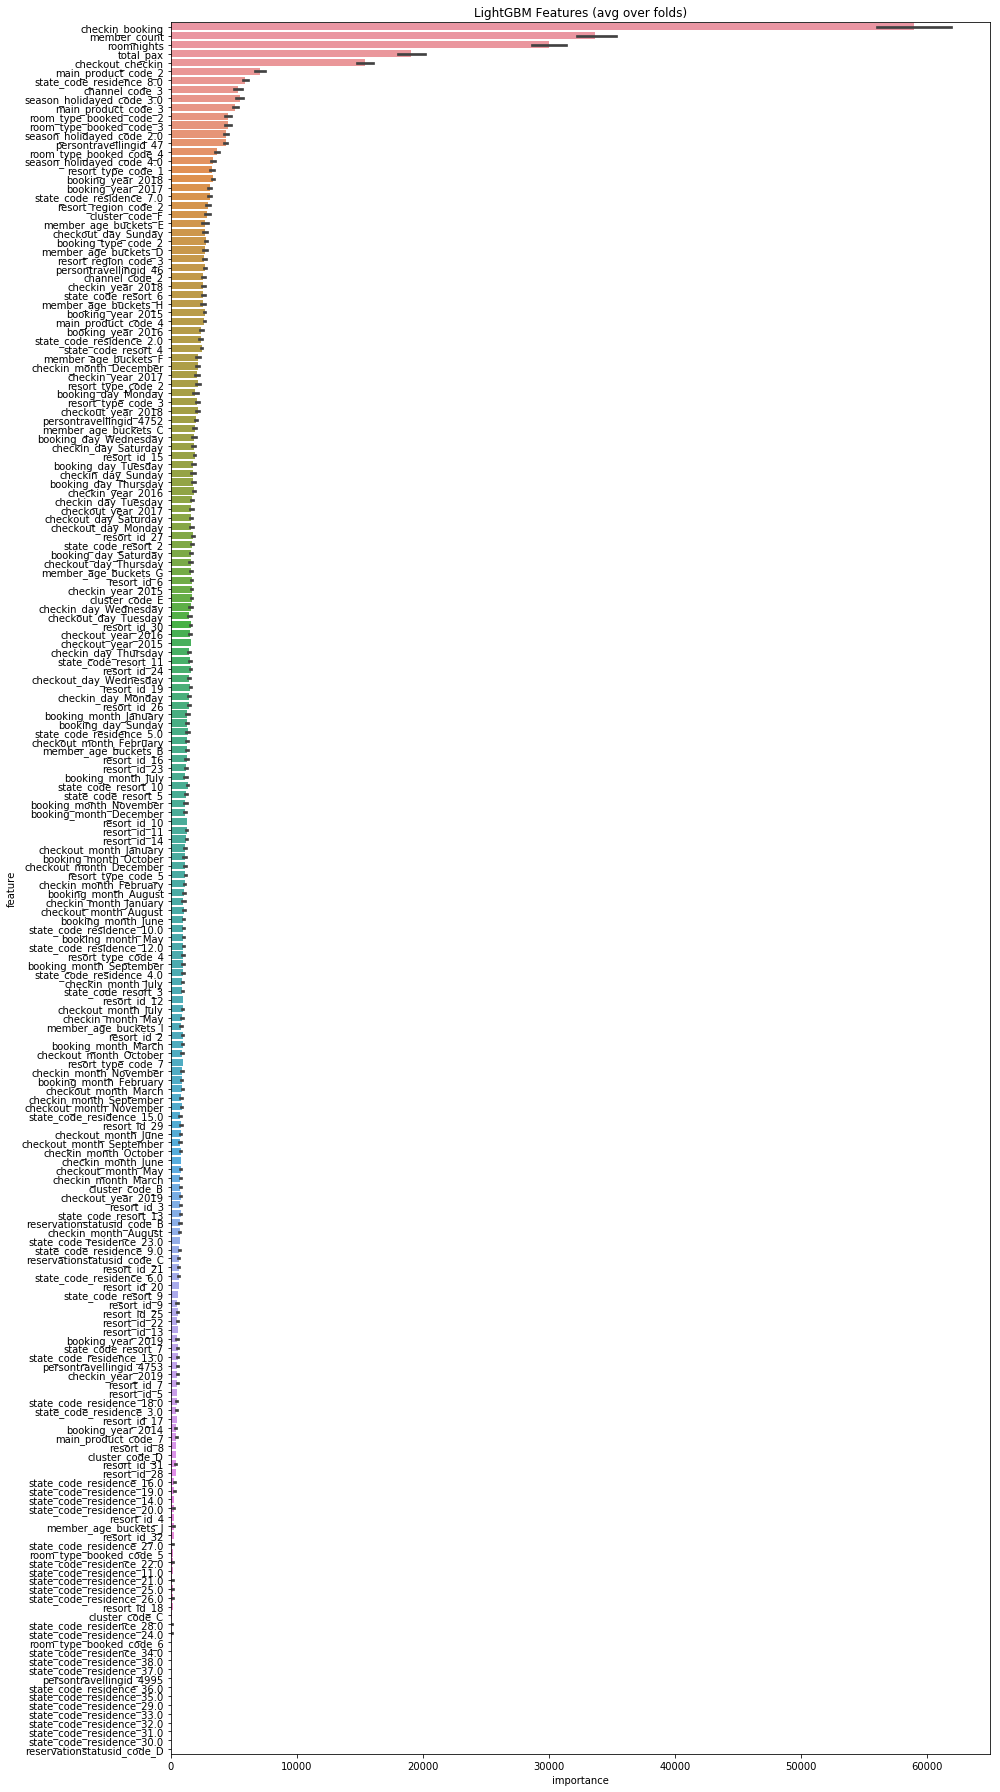

In [164]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [165]:
sub_df = pd.DataFrame({"reservation_id":pd.read_csv('../input/vidya-clb/test_jwt0mqh/test.csv')["reservation_id"].values})
sub_df["amount_spent_per_room_night_scaled"] = predictions
sub_df.to_csv("submit.csv", index=False)